## Packages

In [25]:
import os
import numpy as np
import pandas as pd
from scipy.stats import mode

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.clustering import *

## Data loading

In [12]:
datatypes = {
    'product_id': 'uint32',
    'client_id': 'uint32',
    'sales_net': 'float64',
    'quantity': 'int32',
    'order_channel': 'object',
    'branch_id': 'uint16',
    'unit_price': 'int8',
    'stock_flow': 'int8',
    'month_order': 'uint8',
    'order_invoice_delta': 'float16'
}

In [13]:
df = load_preprocessed_data(datatypes)
print(df.shape[0] == 63319315)

True


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   product_id           uint32 
 1   client_id            uint32 
 2   sales_net            float64
 3   quantity             int32  
 4   order_channel        object 
 5   branch_id            uint16 
 6   unit_price           int8   
 7   stock_flow           int8   
 8   month_order          uint8  
 9   order_invoice_delta  float16
dtypes: float16(1), float64(1), int32(1), int8(2), object(1), uint16(1), uint32(2), uint8(1)
memory usage: 2.1+ GB


## Clustering

In [15]:
df = categorical_encoding(df)

In [16]:
df.dropna(inplace=True)

## Clients clustering

In [17]:
df_clients = df.drop(columns='product_id').groupby(by='client_id').agg(
                sales_sum=('sales_net', 'sum'),
                quantity_mean=('quantity', 'mean'),
                order_channel_mode=('order_channel', lambda x: mode(x)[0]),
                branch_id_mode=('branch_id', lambda x: mode(x)[0]),
                unit_price_mean=('unit_price', 'mean'),
                stock_flow_mode=('stock_flow', lambda x: mode(x)[0]),
                month_order_mode=('month_order', lambda x: mode(x)[0]),
                order_invoice_delta_mean=('order_invoice_delta', 'mean')
    )

In [18]:
df_clients.head()

,sales_sum,quantity_mean,order_channel_mode,branch_id_mode,unit_price_mean,stock_flow_mode,month_order_mode,order_invoice_delta_mean
client_id,,,,,,,,
6,5.882233e+03,37.550000,1,8470,8.925000,1,7,0.000000
7,1.190777e+03,6.600000,0,7453,13.800000,1,12,0.000000
14,3.103187e+06,35.212192,1,10319,13.864285,1,7,2.964844
18,2.194882e+05,25.929856,0,6654,7.920414,1,1,5.476562
25,3.745861e+02,27.000000,0,2876,13.500000,1,10,0.000000


In [19]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 750,
        "random_state": 0
    }

kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(df_clients)

KMeans(init='random', max_iter=750, n_clusters=4, random_state=0)

In [21]:
df_kmeans = pd.DataFrame(kmeans.transform(df_clients))
df_kmeans.columns = [str(i) for i in range(4)]
df_kmeans['cluster'] = kmeans.predict(df_clients)

In [38]:
df_clients['cluster'] = df_kmeans['cluster']
# df_clients['cluster'] = df_clients['cluster'].astype('category')

In [29]:
df_clients['cluster'].value_counts()

3.0    12389
0.0      336
1.0       32
2.0        2
Name: cluster, dtype: int64

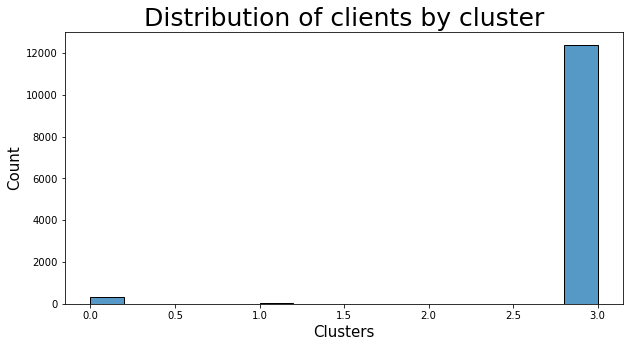

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clients, x='cluster')
plt.title('Distribution of clients by cluster', fontsize=25)
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [41]:
df_clients.columns

Index(['sales_sum', 'quantity_mean', 'order_channel_mode', 'branch_id_mode',
       'unit_price_mean', 'stock_flow_mode', 'month_order_mode',
       'order_invoice_delta_mean', 'cluster'],
      dtype='object')

In [43]:
df_clients.groupby(by='cluster')['order_invoice_delta_mean'].mean()

cluster
0.0    6.488281
1.0    3.400391
2.0    0.190552
3.0    5.324219
Name: order_invoice_delta_mean, dtype: float16

In [45]:
df_clients.groupby(by='cluster')['month_order_mode'].apply(lambda x: mode(x)[0])

cluster
0.0    [8]
1.0    [7]
2.0    [1]
3.0    [8]
Name: month_order_mode, dtype: object

In [46]:
df_clients.groupby(by='cluster')['order_channel_mode'].apply(lambda x: mode(x)[0])

cluster
0.0    [0]
1.0    [0]
2.0    [0]
3.0    [0]
Name: order_channel_mode, dtype: object

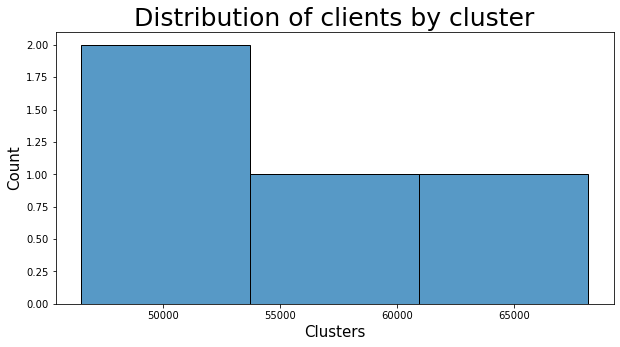

In [40]:
df_clients.groupby(by='cluster')['sales_sum'].mean()